In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, auc
from catboost import CatBoostClassifier
import os
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [111]:
def get_datasets():
    train = pd.read_csv("train_LZdllcl.csv")
    test = pd.read_csv("test_2umaH9m.csv")
    
    return train, test

train, test = get_datasets()
test_id = test.loc[:,'employee_id']

In [66]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [5]:
train.groupby('is_promoted')['employee_id'].count()

is_promoted
0    50140
1     4668
Name: employee_id, dtype: int64

In [6]:
train.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [7]:
train.merge(test, on='employee_id', how='inner')

,employee_id,department_x,region_x,education_x,gender_x,recruitment_channel_x,no_of_trainings_x,age_x,previous_year_rating_x,length_of_service_x,...,education_y,gender_y,recruitment_channel_y,no_of_trainings_y,age_y,previous_year_rating_y,length_of_service_y,KPIs_met >80%_y,awards_won?_y,avg_training_score_y


In [8]:
def perc_stacked_graph(dataset, X, Y, Z, axs, figsize=(5,5)):
    # in a pivot table -> X - row, y - Column, Z - Values
    perc_stacked = dataset.pivot_table(index=[X], columns=Y, values=Z, aggfunc='count').reset_index()
    #perc_stacked.drop(['land_surface_condition'], axis=1)

    perc_stacked = perc_stacked.set_index(perc_stacked[X], drop=True)
    perc_stacked = perc_stacked.drop([X], axis=1)
    for row in perc_stacked.index:
        perc_stacked.loc[row] = perc_stacked.loc[row]/np.sum(perc_stacked.loc[row], axis=0)
    perc_stacked.plot(ax=axs, kind = 'bar', figsize=(15,15))

In [9]:
def sample_boost(X_train, y_train_sub, y):
    #col = 'Quantitative Finance'
    comb_df = pd.DataFrame(X_train)
    comb_df[y] = y_train_sub
    temp_df = comb_df[comb_df[y]==1]
    comb_df = comb_df.drop(temp_df.index, axis=0)
    boost_comb_train, boost_comb_test = train_test_split(comb_df, test_size = len(temp_df)*4)
    boost_comb_test = pd.concat([boost_comb_test, temp_df], axis=0)
    y_train_sub = boost_comb_test[y]
    X_train = boost_comb_test.drop(y, axis=1)
    return X_train, y_train_sub


In [10]:
train.select_dtypes(exclude='int64').columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'previous_year_rating'],
      dtype='object')

In [16]:
y = 'is_promoted'
id_ = 'employee_id'

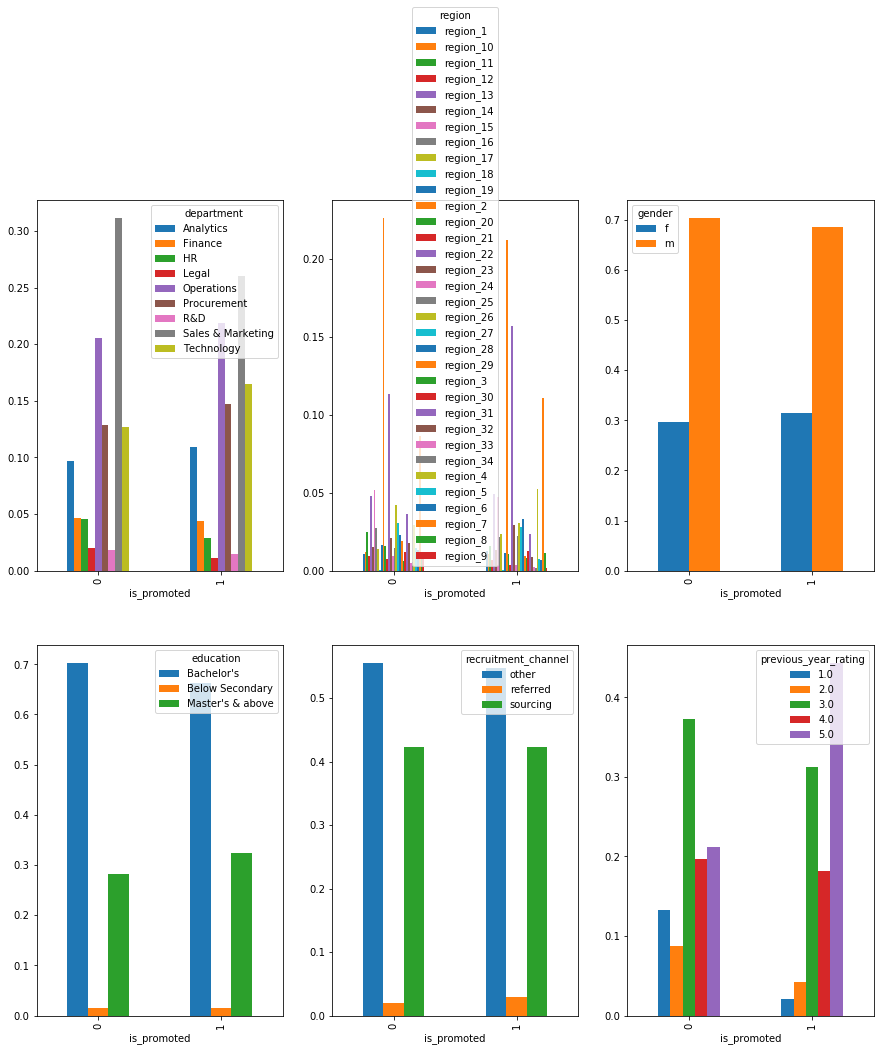

In [60]:

fig, axs = plt.subplots(2,3)

perc_stacked_graph(train, y, "department", id_, axs = axs[0,0])
perc_stacked_graph(train, y, "region", id_, axs = axs[0,1])
perc_stacked_graph(train, y, "gender", id_, axs = axs[0,2])
perc_stacked_graph(train, y, "education", id_, axs = axs[1,0])
perc_stacked_graph(train, y, "recruitment_channel", id_, axs = axs[1,1])
perc_stacked_graph(train, y, "previous_year_rating", id_, axs = axs[1,2])

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


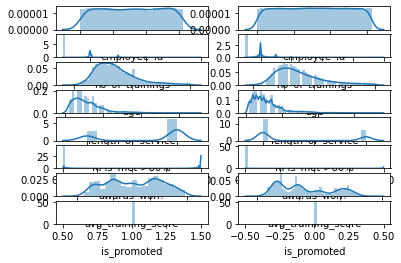

In [47]:
fig, axs = plt.subplots(len(int_cols),2)
int_cols = train.select_dtypes(include='int64').columns
for i,col in zip(range(len(int_cols)),int_cols):
    sns.distplot(train.loc[train[y]==1,col], ax=axs[i,0])
    sns.distplot(train.loc[train[y]==0,col], ax=axs[i,1])

Index(['employee_id', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')


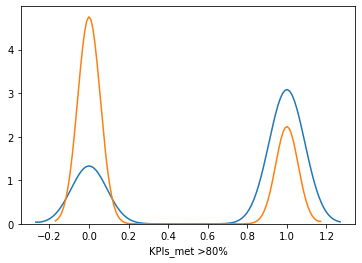

In [30]:
print(train.select_dtypes(include='int64').columns)
col='KPIs_met >80%'
sns.distplot(train.loc[train[y]==1,col], hist=False)
sns.distplot(train.loc[train[y]==0,col], hist=False)

In [64]:
print(len(train))
train.isnull().sum()

54808


employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [108]:
def clean_data(dataset):
    dataset.loc[dataset['department'].isin(['Legal', 'R&D']),'department'] = 'Legal R&D'
    
    dataset.loc[dataset['previous_year_rating'].isnull(),'previous_year_rating'] = -99
    dataset['previous_year_rating'] = dataset['previous_year_rating'].astype('int64')
    
    dataset.loc[dataset['education'].isnull(),'education'] = 'Other'
    dataset = dataset.drop('employee_id', axis=1)
    return dataset
train = clean_data(train)
test = clean_data(test)

In [36]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [95]:
train, test = get_datasets()
train = clean_data(train)
test = clean_data(test)
def add_features(dataset, cols):
    for col in cols:
        temp = dataset.groupby(col).agg({'no_of_trainings':['count','mean','sum'],
                                 'age':['count','mean','sum','min','max'],
                                  'previous_year_rating':['count','mean','sum'],
                                  'length_of_service':['count','mean','sum','min','max'],
                                  'KPIs_met >80%':['count','mean','sum','min','max'],
                                  'awards_won?':['count','mean','sum','min','max'],
                                  'avg_training_score':['count','mean','sum','min','max'],
                                 })
        temp.columns = [('_'+col+'_').join(x) for x in temp.columns]
        dataset = pd.merge(dataset,temp,on=[col],how='left')
    return dataset

train = add_features(train, ['department', 'education', 'gender', 'recruitment_channel'])

In [59]:
def create_test_train(dataset):
    X = dataset.drop(y, axis=1)
    Y = dataset[y]
    X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=2020)
    return(X_train, X_test, y_train, y_test)


X_train, X_test, y_train, y_test = create_test_train(train)
X_train.shape

(43846, 137)

In [60]:
X_train_dum = pd.get_dummies(X_train)
X_test_dum = pd.get_dummies(X_test)


In [83]:
rf = RandomForestClassifier()
rf = rf.fit(X_train_dum, y_train)
pred = rf.predict(X_test_dum)
print("F1 Score: ", f1_score(y_test, pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F1 Score:  0.37225042301184436


In [124]:
rf = RandomForestClassifier(n_estimators = 500, n_jobs=-1, random_state= 2020, verbose=0)
params = {'n_estimators':[500,700,800,1000]} 


In [125]:
rs = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=20, cv=3, verbose=2, random_state=2020, n_jobs=-1)
rs.fit(X_train_dum, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:   55.3s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=500, n_jobs=-1,
                                                    oob

In [126]:
rs.best_params_

{'n_estimators': 800}

In [127]:
rf = RandomForestClassifier(n_estimators = 800, # from random search 
                            random_state= 2020, 
                            verbose=2,
                           min_samples_split=2, # from random search
                           max_depth=None, # from random search
                           min_samples_leaf=1) # from random search

In [115]:
train, test = get_datasets()
test_id = test.loc[:,'employee_id']
train = clean_data(train)
train = add_features(train, add_feat_list)
X_train, X_test, y_train, y_test = create_test_train(train)
X_train_dum = pd.get_dummies(X_train)
X_test_dum = pd.get_dummies(X_test)

In [135]:
xgb1 = xgb.XGBClassifier(#learning_rate =0.3,
                        n_estimators=700,
                        max_depth=3,
                        min_child_weight=1,
                        gamma=0,
                        subsample=1,
                        #colsample_bytree=0.45,
                         colsample_bylevel=0.45,
                        #objective= 'multi:softmax',
                        #scale_pos_weight=0,
                        #seed=2020,
                        verbose = 10)
xg_params = {'learning_rate':[0.035, 0.04,0.045,0.05],
               #'max_depth':[3,7,10],
               #'min_child_weight':[1,2,5,10],
                #'subsample':[0.5,0.7,1]
                #'colsample_bylevel':[0.45,0.7,1],
                #'colsample_bytree':[0.45,0.7,1],
                #'gamma':[0,0.1,0.5,1]
             'n_estimators':[250,350,400]
}

In [168]:
rs = RandomizedSearchCV(estimator=xgb1, param_distributions=xg_params, n_iter=20, cv=2, verbose=10, random_state=2020, n_jobs=-1)
rs.fit(X_train_dum, y_train)
rs.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    7.9s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   14.3s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   14.6s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   19.6s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   19.8s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   29.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   29.4s finished


{'n_estimators': 300}

In [136]:
X_train_boost, y_train_boost = sample_boost(X_train_dum, y_train, y)
gs = GridSearchCV(estimator=xgb1, param_grid=xg_params, cv=2, verbose=10, n_jobs=-1)
gs.fit(X_train_boost, y_train_boost)
gs.best_params_

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:   32.4s remaining:   32.4s
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:   39.6s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:   46.2s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:   51.8s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   56.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   56.2s finished


{'learning_rate': 0.05, 'n_estimators': 400}

In [137]:
# Best XGB params
xgb1 = xgb.XGBClassifier(learning_rate =0.05,
                        n_estimators=400,
                        max_depth=3,
                        min_child_weight=1,
                        gamma=0,
                        subsample=1,
                        colsample_bytree=1,
                        colsample_bylevel=0.45,
                        #scale_pos_weight=0,
                        #seed=2020,
                        verbose = 2)

In [ ]:
# Submission File
train, test = get_datasets()
full_df_2 = clean_data(train)
full_df_2 = add_features(full_df_2, add_feat_list)

full_df_y = full_df_2[y]
full_df_2 = full_df_2.loc[:,imp_df['Feature']]
full_df_x = pd.get_dummies(full_df_2)

X_train_boost, y_train_boost = sample_boost(full_df_x, full_df_y, y)
xgb1 = xgb1.fit(X_train_boost, y_train_boost)

test2 = clean_data(test)
test2 = add_features(test2, add_feat_list)
test2 = test2.loc[:,imp_df['Feature']]
test_dum = pd.get_dummies(test2)

final_pred = xgb1.predict(test_dum)
final_sub_df = pd.DataFrame(test.loc[:,'employee_id'])
final_sub_df[y] = final_pred


In [139]:
final_sub_df.to_csv( "all_feat_xgb.csv", index=False)
final_pred.sum()

836

In [102]:
xgb1 = xgb.XGBClassifier(n_estimators=1000, random_state=0, learning_rate=0.1)

In [97]:
add_feat_list = ['department', 'education', 'gender', 'recruitment_channel']

In [103]:


for col in ['department', 'education', 'gender', 'recruitment_channel']:
    train, test = get_datasets()
    train = clean_data(train)
    test = clean_data(test)
    train = add_features(train, [col])
    X_train, X_test, y_train, y_test = create_test_train(train)
    X_train_dum = pd.get_dummies(X_train)
    X_test_dum = pd.get_dummies(X_test)

    X_train_boost, y_train_boost = sample_boost(X_train_dum, y_train, y)
    xgb1 = xgb1.fit(X_train_boost, y_train_boost)
    pred = xgb1.predict(X_test_dum)
    print("F1 Score: ", f1_score(y_test, pred))

F1 Score:  0.5058175137783221
F1 Score:  0.4999999999999999
F1 Score:  0.5024154589371981
F1 Score:  0.4886711573790569


In [96]:
train, test = get_datasets()
train = clean_data(train)
train = add_features(train, [col])
X_train, X_test, y_train, y_test = create_test_train(train)
X_train_dum = pd.get_dummies(X_train)
X_test_dum = pd.get_dummies(X_test)

X_train_boost, y_train_boost = sample_boost(X_train_dum, y_train, y)
xgb1 = xgb1.fit(X_train_boost, y_train_boost)
pred = xgb1.predict(X_test_dum)
print("F1 Score: ", f1_score(y_test, pred))

F1 Score:  0.498792270531401


In [126]:
imp_df = []
for col, imp in zip(X_train_boost.columns, xgb1.feature_importances_):
    imp_df.append([col,imp])
imp_df = pd.DataFrame(imp_df, columns=['Feature', 'Importance'])

In [127]:
imp_df = imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)
imp_df = imp_df.loc[imp_df['Importance']>= 0.005,:]
imp_df

,Feature,Importance
0,department_Procurement,0.085298
1,KPIs_met >80%,0.076974
2,avg_training_score_department_mean,0.071567
3,awards_won?,0.059594
4,KPIs_met >80%_department_mean,0.058640
5,age_department_count,0.055003
6,avg_training_score_department_min,0.051614
7,awards_won?_department_mean,0.046633
8,avg_training_score,0.042332
9,no_of_trainings_department_count,0.028854


In [141]:
full_df_x.columns

Index(['department_Procurement', 'KPIs_met >80%',
       'avg_training_score_department_mean', 'awards_won?',
       'KPIs_met >80%_department_mean', 'age_department_count',
       'avg_training_score_department_min', 'awards_won?_department_mean',
       'avg_training_score', 'no_of_trainings_department_count',
       'no_of_trainings_department_sum', 'KPIs_met >80%_department_sum',
       'length_of_service_department_sum', 'previous_year_rating',
       'length_of_service_department_mean', 'age_department_mean',
       'age_department_sum', 'previous_year_rating_department_mean',
       'previous_year_rating_department_sum',
       'previous_year_rating_department_count', 'department_Technology',
       'region_region_22', 'department_Analytics', 'age_education_sum',
       'region_region_4', 'region_region_30',
       'length_of_service_education_mean', 'age_gender_mean',
       'age_department_min', 'KPIs_met >80%_education_mean',
       'length_of_service_recruitment_channel_sum'